# <center><u>Customers happiness prediction for delivery service</u></center>


# Business Problem

**Goal(s):**

Predict if a customer is happy or not based on the answers they give to questions asked.

**Data Description:**

- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
- X1 = my order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted to order
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

**Success Metrics:**

Reach an accuracy score of 73% or higher, or convince us why your solution is superior. We are definitely interested in every solution and insight you can provide us.


In [1]:
# import main libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import mean, std


import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron
import warnings

warnings.filterwarnings("ignore")

# Data collection and explorartion


In [2]:
# Load the dataset
cust_data = pd.read_csv("ACME-HappinessSurvey2020.csv")

In [3]:
# Display some rows first and last 5 rows of the dataset

pd.concat([cust_data.head(), cust_data.tail()])

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5
125,0,5,3,2,5,5,5


In [4]:
# Dimensions of dataset (rows , columns)
cust_data.shape

(126, 7)

The dataset contains 126 observations, 6 independent variables (X) and 1 dependent variable (Y).


In [5]:
# Show dataset information,
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


We can see that there is no Null value, all values are numeric (int64)


#### Check missing data


In [9]:
# Check missing data
print(
    "Number of cases with missing values: "
    + str(cust_data.isnull().values.ravel().sum())
)

Number of cases with missing values: 0


There is no missing data


Scaling data is not needed since all the variables are in range [1,5]


In [10]:
# Diplay dataset decription
cust_data.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


# Exploratory Data Analysis(EDA)


### Exploration and Visualization

We try to find out the relative proportion of happy and unhappy customers


Happy customers: 69
Unhappy customers: 57
Proportion of Happy customers: 0.5476190476190477
Proportion of Unhappy customers: 0.4523809523809524


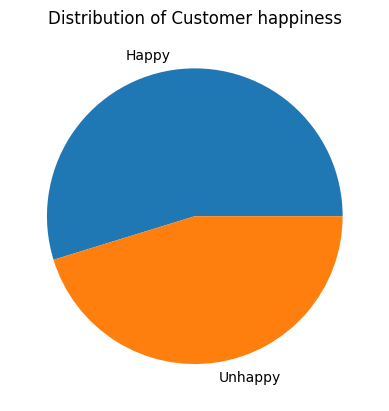

In [11]:
print("Happy customers: " + str(len(cust_data[cust_data["Y"] == 1])))
print("Unhappy customers: " + str(len(cust_data[cust_data["Y"] == 0])))
print(
    "Proportion of Happy customers: "
    + str(len(cust_data[cust_data["Y"] == 1]) / cust_data.shape[0])
)
print(
    "Proportion of Unhappy customers: "
    + str(len(cust_data[cust_data["Y"] == 0]) / cust_data.shape[0])
)

# To see how small are the number of Fraud transactions
cust_data_pi = cust_data.copy()
cust_data_pi["Happiness"] = np.where(cust_data_pi["Y"] == 1, "Happy", "Unhappy")

%matplotlib inline
cust_data_pi["Happiness"].value_counts().plot(kind="pie")
plt.title("Distribution of Customer happiness")
plt.ylabel("")
plt.show()

The dataset is balanced with 51% of happy customers and 49% of unhappy customers about the delivery service. It means that a large number of customers are unhappy with the delivery service, which means that the company must make additional effort to reduce the unhappy customer rate.


### Bivariate analysis between features and target variables


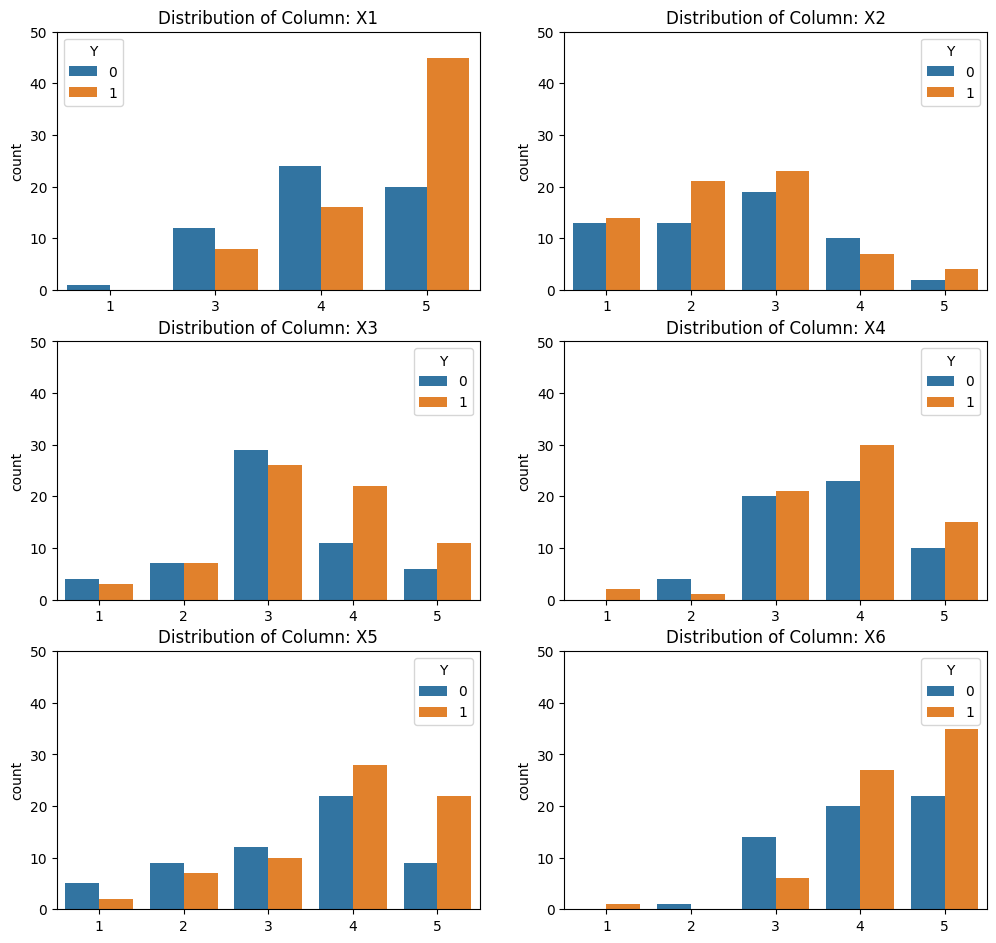

In [12]:
import matplotlib.colors as mcolors

# Plot the distributions of the features
columns = cust_data.iloc[:, 1:8].columns
plt.figure(figsize=(12, 30 * 4))
grids = gridspec.GridSpec(30, 2)
for grid, index in enumerate(cust_data[columns]):
    ax = plt.subplot(grids[grid])
    sns.countplot(cust_data, x=index, hue="Y")
    ax.set_xlabel("")
    ax.set_ylim(0, 50)
    ax.set_title("Distribution of Column: " + str(index))
plt.show()

We can see that the most unhappy customers gives bad feedback in X2 (Contents of my order was as I expected) and X3 (I ordered everything I wanted to order) variables


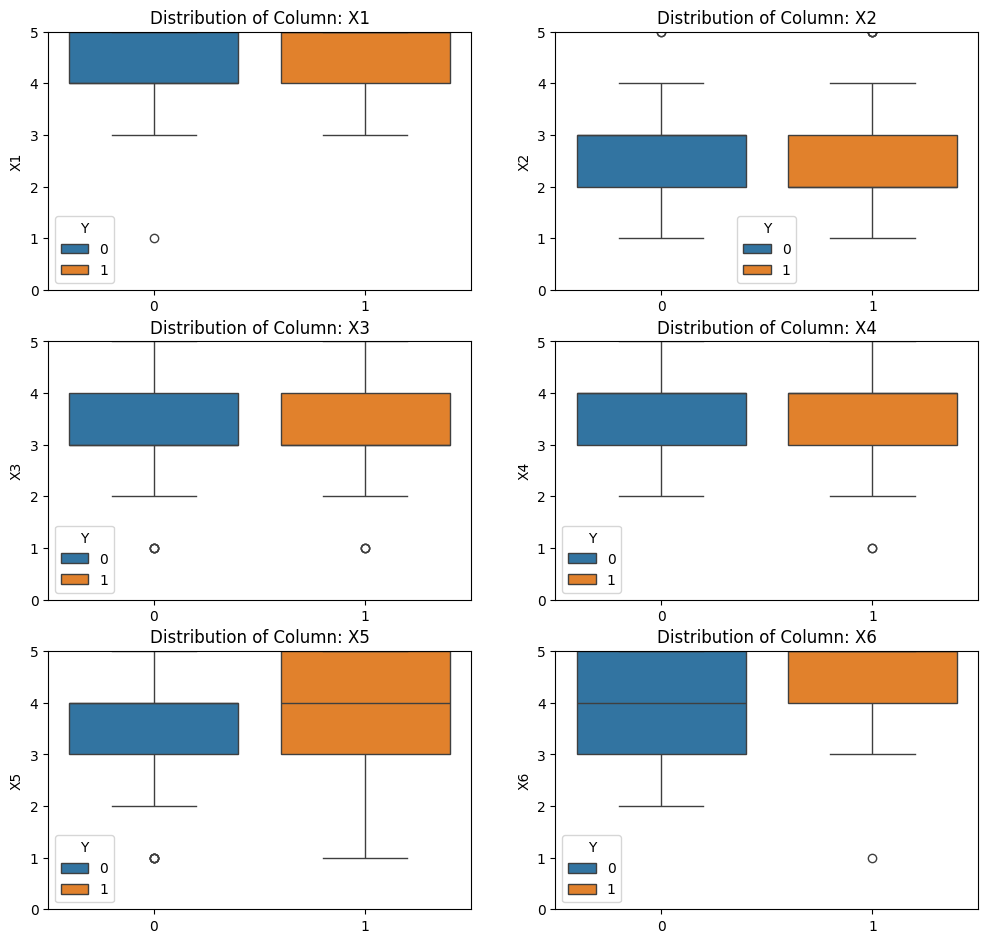

In [13]:
import matplotlib.colors as mcolors

# Plot the distributions of the features
columns = cust_data.iloc[:, 1:8].columns
plt.figure(figsize=(12, 30 * 4))
grids = gridspec.GridSpec(30, 2)
for grid, index in enumerate(cust_data[columns]):
    ax = plt.subplot(grids[grid])
    sns.boxplot(cust_data, x="Y", y=index, hue="Y")
    ax.set_xlabel("")
    ax.set_ylim(0, 5)
    ax.set_title("Distribution of Column: " + str(index))
plt.show()

<Axes: >

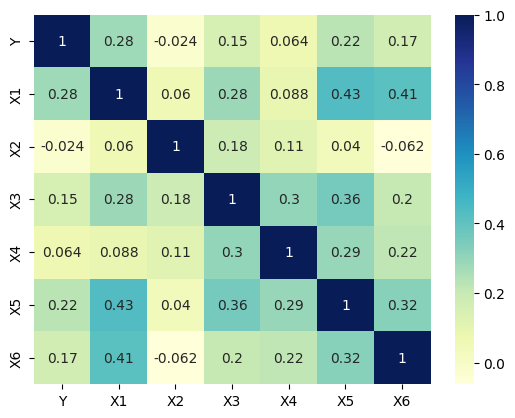

In [14]:
# The heatmap correlation matrix
sns.heatmap(cust_data.corr(), cmap="YlGnBu", annot=True)

The heatmap correlation matrix shows that there is no high strong correlation between the features, despite some correlation between
X1 and (X5 and X6)


# Modelling

Now we start modelling.
First we divide the data into response and features. And also make the train-test split of the data for further modelling and validation.


### Split dataset after Normalization and Stratification


In [15]:
# Splitting the X and Y into the
# Training set and Testing set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate response and features
y = cust_data["Y"]
X = cust_data.iloc[:, 1:7]

# Create a stratified split to maintain the class distribution
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Preprocess the data
scaler = StandardScaler().set_output(transform="pandas")
X_scaled = scaler.fit_transform(X)
# split the data to train the final model
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
type(X_scaled)

pandas.core.frame.DataFrame

### Define scoring function


In [17]:
from sklearn.metrics import make_scorer, recall_score


# Define a custom scoring function
def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[0], average=None)[0]


# Create a scorer based on the custom function
scorer = make_scorer(recall_class_0, greater_is_better=True)

### Function for evaluating model


In [18]:
import pandas as pd

# Global dataframe to store the metrics
global_df = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Precision",
        "Recall",
        "Precision_0",
        "Precision_1",
        "Recall_0",
        "Recall_1",
        "F1_Score",
    ]
)

In [95]:
def evaluate_model(model, model_name, X_test=X_test):
    """
    Calculates and displays various machine learning metrics for a given model.

    Parameters:
    model (object): The trained machine learning model.
    model_name (str): The name of the model.
    """

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the metrics
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_score_v = f1_score(y_test, y_pred)

    # Print the metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision (0): {precision_0:.2f}")
    print(f"Precision (1): {precision_1:.2f}")
    print(f"Recall (0): {recall_0:.2f}")
    print(f"Recall (1): {recall_1:.2f}")
    print(f"F1-Score: {f1_score_v:.2f}")

    # Check if the model name already exists in the dataframe
    if model_name in global_df["Model"].values:
        # Update the existing row
        global_df.loc[global_df["Model"] == model_name] = [
            model_name,
            accuracy,
            precision,
            recall,
            precision_0,
            precision_1,
            recall_0,
            recall_1,
            f1_score_v,
        ]
    else:
        # Add a new row to the dataframe
        global_df.loc[len(global_df)] = [
            model_name,
            accuracy,
            precision,
            recall,
            precision_0,
            precision_1,
            recall_0,
            recall_1,
            f1_score_v,
        ]

### Function for diplaying model metrics in Bar chart


In [20]:
import matplotlib.pyplot as plt


# Assuming you have the global dataframe 'global_df'
def display_models():
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the side-by-side bar chart for Accuracy and Recall_Class0
    x = np.arange(len(global_df["Model"]))
    width = 0.35

    ax.bar(x - width / 2, global_df["Accuracy"], width, color="blue", label="Accuracy")
    ax.bar(
        x + width / 2,
        global_df["Recall_0"],
        width,
        color="green",
        label="Recall (Class 0)",
    )

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(global_df["Model"])

    # Set the y-axis label and title
    ax.set_ylabel("Value")
    ax.set_title("Model Performance Metrics")

    # Add a horizontal line at the 0.73 threshold
    ax.axhline(y=0.73, color="r", linestyle="--", label="Threshold (0.73)")

    # Add legends
    ax.legend()

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=30, ha="right")

    # Adjust the layout to prevent overlapping labels
    plt.tight_layout()

    # Display the plot
    plt.show()

## Training and comparing models


### RandomForest


#### Basic RandomForest


In [21]:
# Using SKLEARN module for random forest
from sklearn.ensemble import RandomForestClassifier


# Fit and predict
naive_rfc = RandomForestClassifier(random_state=42)
naive_rfc.fit(X_train, y_train)
naive_test_preds = naive_rfc.predict(X_test)

In [22]:
evaluate_model(naive_rfc, "RandomForestClassifier")

Model: RandomForestClassifier
Accuracy: 0.65
Precision: 0.73
Recall: 0.57
Precision (0): 0.60
Precision (1): 0.73
Recall (0): 0.75
Recall (1): 0.57
F1-Score: 0.64


#### RandomForest with GridSearchCV


In [23]:
# Model selection - Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring=scorer,
)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_

# Train the model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predictions
# y_pred = best_rf_model.predict(X_test)

# Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


RandomForestClassifier(random_state=42)

In [24]:
evaluate_model(best_rf_model, "RandomForestClassifier_GridSearchCV")

Model: RandomForestClassifier_GridSearchCV
Accuracy: 0.65
Precision: 0.73
Recall: 0.57
Precision (0): 0.60
Precision (1): 0.73
Recall (0): 0.75
Recall (1): 0.57
F1-Score: 0.64


#### RandomForest with RandomizedSearchCV


In [25]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 4, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"],
}

# GridSearchCV for parameter tuning
grid_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    # param_grid=param_grid_rf,
    cv=5,
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search_rf.fit(X_train, y_train)

# Training the final Random Forest model on the full training set using the best parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predicting on the test set with the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test)

# Calculating the accuracy on the test set for Random Forest
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy on the test set for Random Forest: {test_accuracy_rf}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy on the test set for Random Forest: 0.7307692307692307


In [26]:
# scoring=accuracy
evaluate_model(best_rf_model, "RandomForestClassifier_RandomizedSearchCV")

Model: RandomForestClassifier_RandomizedSearchCV
Accuracy: 0.73
Precision: 0.73
Recall: 0.79
Precision (0): 0.73
Precision (1): 0.73
Recall (0): 0.67
Recall (1): 0.79
F1-Score: 0.76


In [27]:
print(best_rf_model)

RandomForestClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=150, random_state=42)


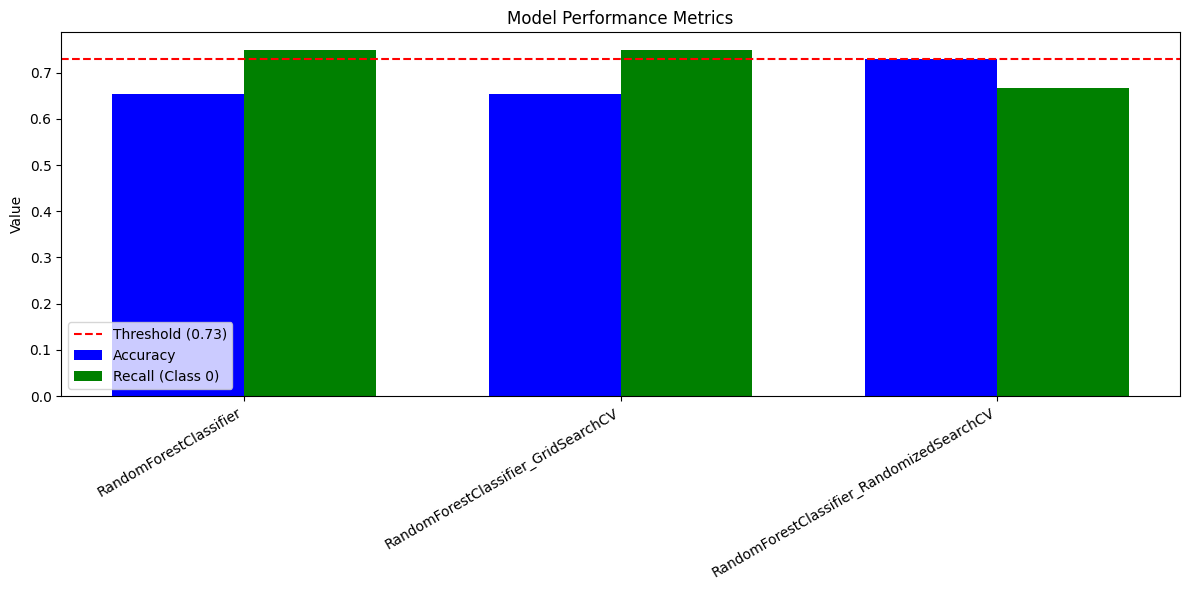

In [28]:
display_models()

### Decision Tree


#### Decision Tree Basic


In [29]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [30]:
evaluate_model(dt_model, "DecisionTreeClassifier")

Model: DecisionTreeClassifier
Accuracy: 0.65
Precision: 0.73
Recall: 0.57
Precision (0): 0.60
Precision (1): 0.73
Recall (0): 0.75
Recall (1): 0.57
F1-Score: 0.64


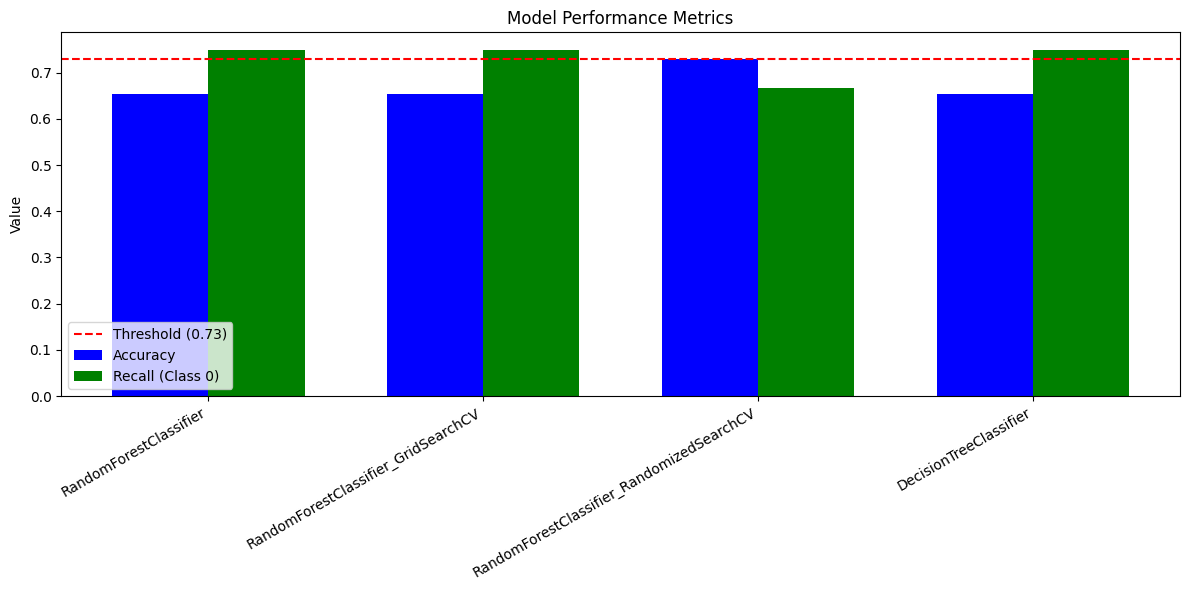

In [31]:
display_models()

#### Decision Tree GridSearchCV


In [32]:
dt_model = DecisionTreeClassifier(random_state=42)
param_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 5),
}
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_dt,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="accuracy",
)

grid_dt.fit(X_train, y_train)

# Best parameters
best_params = grid_dt.best_params_

# Train the model with best parameters
best_dt_model = grid_dt.best_estimator_
best_dt_model.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


DecisionTreeClassifier(max_depth=1, random_state=42)

In [33]:
evaluate_model(best_dt_model, "DecisionTreeClassifier_GridSearchCV")

Model: DecisionTreeClassifier_GridSearchCV
Accuracy: 0.73
Precision: 0.73
Recall: 0.79
Precision (0): 0.73
Precision (1): 0.73
Recall (0): 0.67
Recall (1): 0.79
F1-Score: 0.76


#### Decision Tree RandomizedSearchCV


In [34]:
# Define your Decision Tree classifier
clf = DecisionTreeClassifier()

# Define the parameter grid you want to search through
param_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 5),
}
grid_dt = RandomizedSearchCV(
    estimator=dt_model,
    # param_grid=param_dt,
    param_distributions=param_dt,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=scorer,
    random_state=42,
)
# Create GridSearchCV instance with custom scoring
# grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=5)

# Fit the grid search to your data
grid_dt.fit(X_train, y_train)


# Best parameters
best_params = grid_dt.best_params_

# Train the model with best parameters
best_dt_model = grid_dt.best_estimator_
best_dt_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2,
                       min_samples_split=9, random_state=42)

In [35]:
evaluate_model(best_dt_model, "DecisionTreeClassifier_RandomSearchCV")

Model: DecisionTreeClassifier_RandomSearchCV
Accuracy: 0.58
Precision: 0.67
Recall: 0.43
Precision (0): 0.53
Precision (1): 0.67
Recall (0): 0.75
Recall (1): 0.43
F1-Score: 0.52


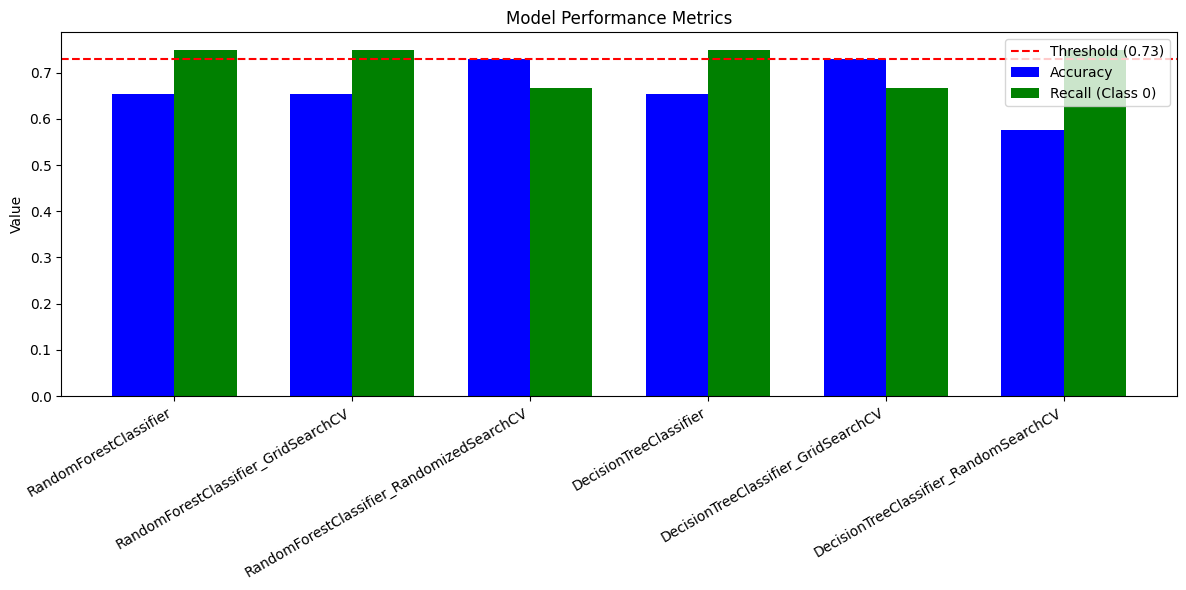

In [36]:
display_models()

### Logistic Regression


#### Logistic Regression GridSearchCV


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a simple pipeline with standardization and logistic regression
pipeline = Pipeline([("logreg", LogisticRegression())])

# Define the parameter grid for GridSearchCV
# param_grid = {
#     'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'logreg__solver': ['liblinear', 'lbfgs']  # Optimization algorithms
# }
param_grid = {
    "logreg__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "logreg__penalty": ["none", "elasticnet", "l1", "l2"],
    "logreg__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "logreg__class_weight": [None, "balanced", 0.25],
}
# Initialize GridSearchCV with the logistic regression pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", verbose=0)

# Fit GridSearchCV on the data
grid_search.fit(X_train, y_train)
best_lr_model = grid_search.best_estimator_
best_lr_model.fit(X_train, y_train)
# Best model parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validation score: 0.60


In [38]:
evaluate_model(best_lr_model, "LogisticRegression_GSCV")

Model: LogisticRegression_GSCV
Accuracy: 0.65
Precision: 0.63
Recall: 0.86
Precision (0): 0.71
Precision (1): 0.63
Recall (0): 0.42
Recall (1): 0.86
F1-Score: 0.73


### Max Voting


In [39]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

model1 = LogisticRegression(random_state=1)
model2 = DecisionTreeClassifier(random_state=1)
model3 = KNeighborsClassifier()
model_max_vt = VotingClassifier(
    estimators=[("lr", model1), ("dt", model2), ("knn", model3)]
)
model_max_vt.fit(X_train, y_train)
print("Accuracy Max voting: %.3f" % model_max_vt.score(X_test, y_test))

Accuracy Max voting: 0.692


In [40]:
evaluate_model(model_max_vt, "MaxVoting")

Model: MaxVoting
Accuracy: 0.69
Precision: 0.67
Recall: 0.86
Precision (0): 0.75
Precision (1): 0.67
Recall (0): 0.50
Recall (1): 0.86
F1-Score: 0.75


### XGBoost


#### XGBoost basic


In [41]:
# read data

model_xgbst = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)
# fit model
model_xgbst.fit(X_train, y_train)
# make predictions
preds = model_xgbst.predict(X_test)
evaluate_model(model_xgbst, "XGBoostCalissifier")

Model: XGBoostCalissifier
Accuracy: 0.65
Precision: 0.65
Recall: 0.79
Precision (0): 0.67
Precision (1): 0.65
Recall (0): 0.50
Recall (1): 0.79
F1-Score: 0.71


#### XGBoost with RandomizedSearchCV


In [99]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss",)

# Create a parameter grid with narrowed focus and increased regularization
param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "subsample": [0.7, 0.8],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "reg_lambda": [1, 1.5, 2, 3],  # Increased regularization
    "reg_alpha": [0.1, 0.2, 0.3],
    "min_child_weight": [1, 3, 5, 7],
}



grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    # param_grid=param_grid,
    cv=stratified_kfold,
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
    n_iter=200,
    random_state=42
)

# Performing the grid search
grid_search.fit(X_scaled, y)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy found: ", grid_search.best_score_)


# Training the final model on the full training set using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predicting on the test set with the best parameters
y_pred = best_model.predict(X_test)


evaluate_model(best_model, "XGBoost_RandomizedSearchCV2")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best cross-validated accuracy found:  0.6433846153846153
Model: XGBoost_RandomizedSearchCV2
Accuracy: 0.77
Precision: 0.72
Recall: 0.93
Precision (0): 0.88
Precision (1): 0.72
Recall (0): 0.58
Recall (1): 0.93
F1-Score: 0.81


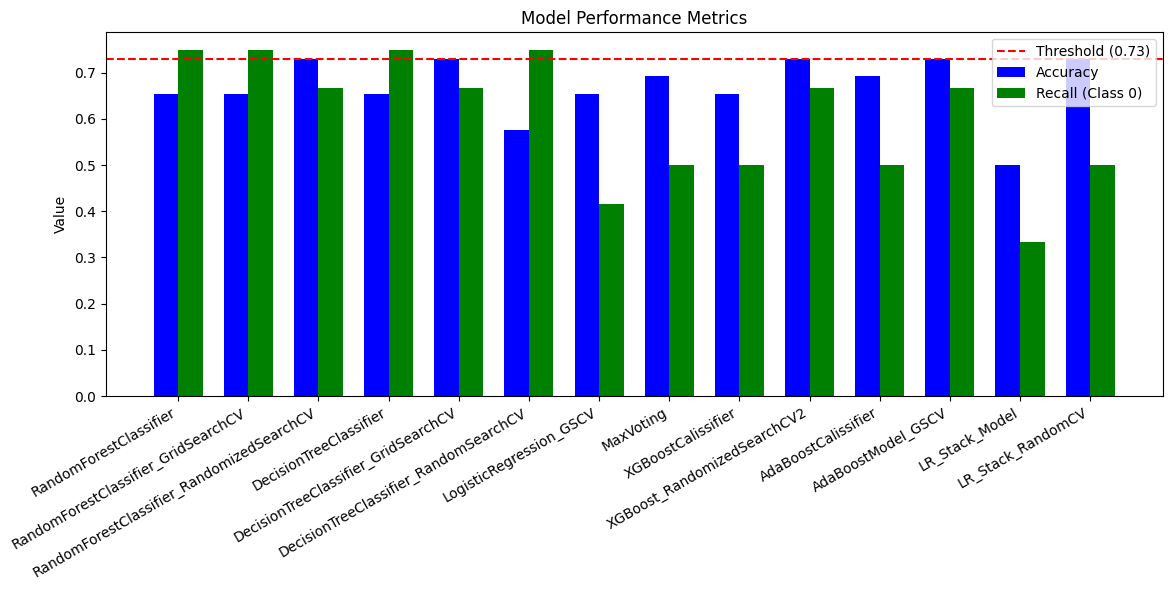

In [67]:
display_models()

## AdaBoost


#### AdaBoost Basic


In [44]:
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier


# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)

# Train Adaboost Classifer
model_ada = abc.fit(X_train, y_train)


# Predict the response for test dataset
y_pred = model_ada.predict(X_test)

evaluate_model(model_ada, "AdaBoostCalissifier")

Model: AdaBoostCalissifier
Accuracy: 0.69
Precision: 0.67
Recall: 0.86
Precision (0): 0.75
Precision (1): 0.67
Recall (0): 0.50
Recall (1): 0.86
F1-Score: 0.75


#### AdaBoost GridSearchCV


In [45]:
# Ada Boost grd parameters
ada_parameter = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.3, 0.5],
    "algorithm": ["SAMME", "SAMME.R"],
    "random_state": [42],
}
# Run Ada Boost GridSearchCV
ada_grid_search = GridSearchCV(model_ada, param_grid=ada_parameter, cv=5, n_jobs=-1)
ada_grid_search.fit(X_train, y_train)
ada_pred = ada_grid_search.predict(X_test)
# Get best parameters
ada_grid_search.best_params_
# Best AdaBoost model
best_ada_model = ada_grid_search.best_estimator_

In [49]:
print(best_ada_model)

AdaBoostClassifier(learning_rate=0.01, random_state=42)


In [50]:
evaluate_model(best_ada_model, "AdaBoostModel_GSCV")

Model: AdaBoostModel_GSCV
Accuracy: 0.73
Precision: 0.73
Recall: 0.79
Precision (0): 0.73
Precision (1): 0.73
Recall (0): 0.67
Recall (1): 0.79
F1-Score: 0.76


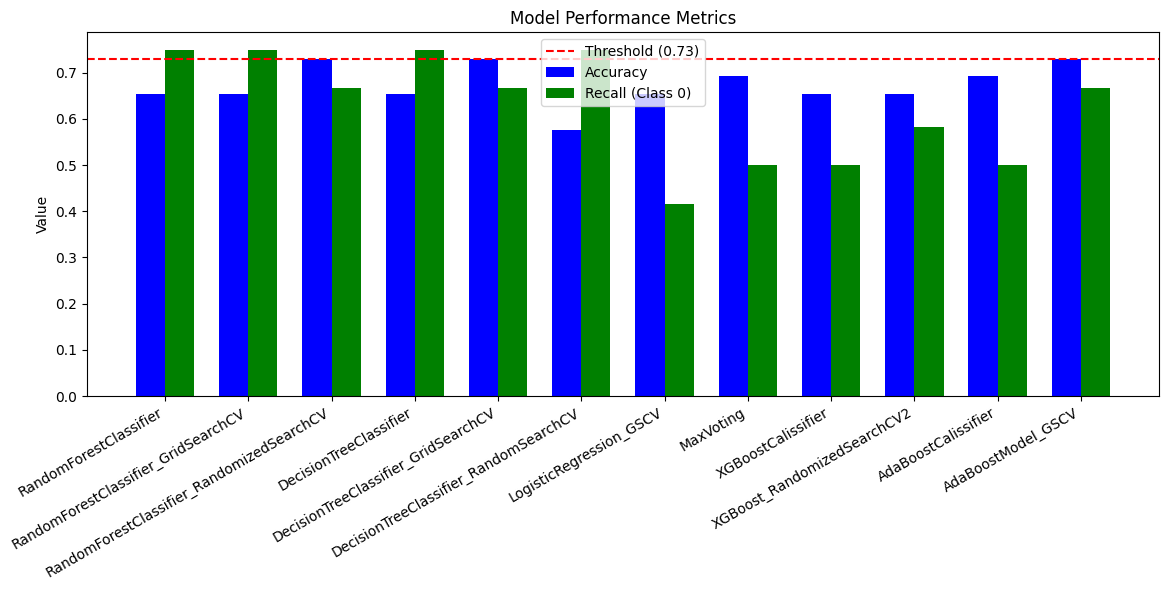

In [51]:
display_models()

## Stacking


In [52]:
# define the base models
level0 = list()
level0.append(
    (
        "lr",
        RandomForestClassifier(random_state=42),
    )
)
level0.append(("knn", KNeighborsClassifier()))
level0.append(("dt", DecisionTreeClassifier(random_state=42)))


# define meta learner model
# level1 = DecisionTreeClassifier(random_state=42)
level1 = LogisticRegression(random_state=42)
# define the stacking ensemble
lr_stack_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
lr_stack_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', RandomForestClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [53]:
evaluate_model(lr_stack_model, "LR_Stack_Model")

Model: LR_Stack_Model
Accuracy: 0.50
Precision: 0.53
Recall: 0.64
Precision (0): 0.44
Precision (1): 0.53
Recall (0): 0.33
Recall (1): 0.64
F1-Score: 0.58


#### Stacking with RandomizedSearchCV


In [54]:
# Define base models
estimators = [
    ("rf", RandomForestClassifier()),
    ("dt", DecisionTreeClassifier()),
    # ("ada", AdaBoostClassifier()),
    # ("svc", SVC()),
]

# Define the meta-model
meta_model = LogisticRegression()
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    # , cv=5
)
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    "rf__n_estimators": [50, 100, 150],
    "rf__max_depth": [3, 4, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["auto", "sqrt"],
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": range(1, 10),
    "dt__min_samples_split": range(1, 10),
    "dt__min_samples_leaf": range(1, 5),
    # "ada__n_estimators": [10, 50, 100],
    # "svc__C": [0.1, 1, 10],
    # "svc__gamma": [0.001, 0.01, 0.1],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=stacking_clf,
    param_distributions=param_grid,
    # param_grid=param_grid,
    n_iter=200,
    # cv=5,
    random_state=42,
    n_jobs=-1,
    scoring=scorer,
)
# Fit the model
random_search.fit(X_train, y_train)
# Best estimator
best_stck_model = random_search.best_estimator_

In [55]:
evaluate_model(best_stck_model, "LR_Stack_RandomCV")

Model: LR_Stack_RandomCV
Accuracy: 0.73
Precision: 0.68
Recall: 0.93
Precision (0): 0.86
Precision (1): 0.68
Recall (0): 0.50
Recall (1): 0.93
F1-Score: 0.79


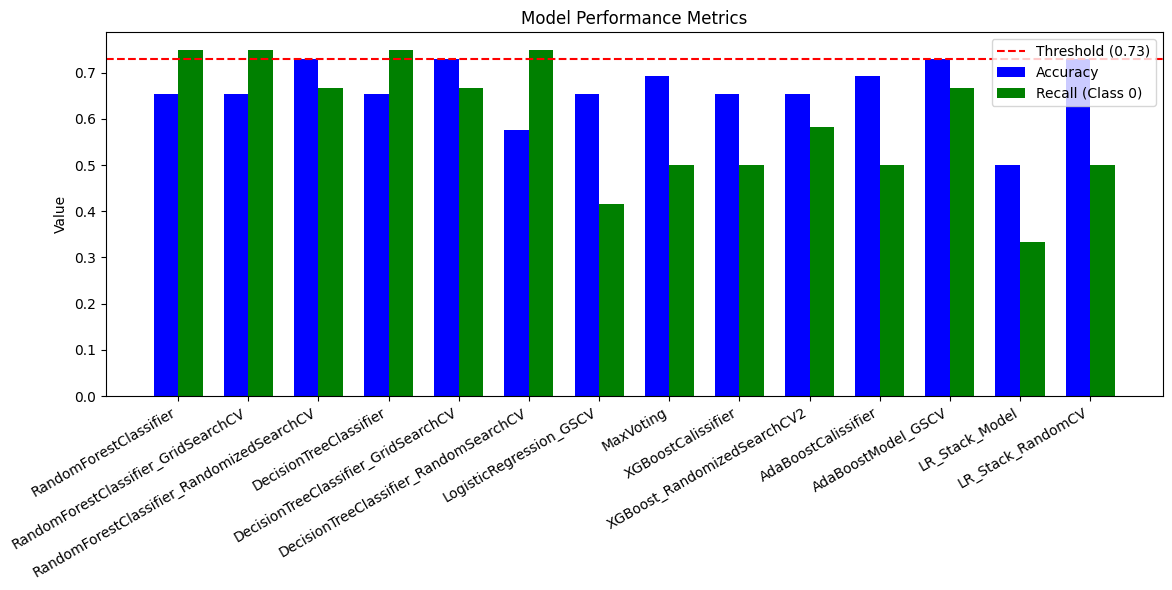

In [56]:
display_models()

## Recursive Feature Elimination (FRE)


Run the Recursive Feature Elimination (RFE) using GridsearchCV for mutiple classifiers and estimators.


In [57]:
# Get a list of models to evaluate
def get_models(n_features):
    models = dict()
    
    # Define classifiers
    classifiers = {
        "DecisionTree": DecisionTreeClassifier(),
        "RandomForest": RandomForestClassifier(),
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(probability=True),
        "XGBoost": XGBClassifier(),
    }

    for name, classifier in classifiers.items():
        # Logistic Regression
        rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_features)
        models[f"{name}_lr_{n_features}"] = Pipeline(
            steps=[("s", rfe), ("m", classifier)]
        )

        # Perceptron
        rfe = RFE(estimator=Perceptron(), n_features_to_select=n_features)
        models[f"{name}_per_{n_features}"] = Pipeline(
            steps=[("s", rfe), ("m", classifier)]
        )

        # Decision Tree
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features)
        models[f"{name}_cart_{n_features}"] = Pipeline(
            steps=[("s", rfe), ("m", classifier)]
        )

        # Random Forest
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features)
        models[f"{name}_rf_{n_features}"] = Pipeline(
            steps=[("s", rfe), ("m", classifier)]
        )

        # Gradient Boosting
        rfe = RFE(
            estimator=GradientBoostingClassifier(), n_features_to_select=n_features
        )
        models[f"{name}_gbm_{n_features}"] = Pipeline(
            steps=[("s", rfe), ("m", classifier)]
        )

        # XGBoost
        rfe = RFE(estimator=XGBClassifier(), n_features_to_select=n_features)
        # model = DecisionTreeClassifier()
        models[f"{name}_xgb_{n_features}"] = Pipeline(
            steps=[("s", rfe), ("m", classifier)]
        )

    return models


# Evaluate a given model using cross-validation
def evaluate_model_2(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores_acc = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    # precision_score(y_test, y_pred, pos_label=0)
    scores_rec = cross_val_score(model, X, y, scoring="recall", cv=cv, n_jobs=-1)
    return scores_acc, scores_rec


# Initialize a list to store the results
results_list = []

# Iterate over the range of n_features_to_select
for n_features in range(1, 7):
    # Get the models to evaluate
    models = get_models(n_features)
    # print(models)
    # Evaluate the models and store results
    for name, model in models.items():
        rfe_t = model.named_steps["s"]
        rfe_t.fit(X_train, y_train)
        features_selected = X_train.columns[rfe_t.get_support()].values
        # print(features_selected)
        scores_acc, scores_rec = evaluate_model_2(model, X, y)
        mean_acc = mean(scores_acc)
        mean_rec = mean(scores_rec)
        std_acc = std(scores_acc)

        # Append the results to the list
        results_list.append(
            {
                "Model": name,
                "n_features": n_features,
                "Selected Features": features_selected,
                "Mean Accuracy": mean_acc,
                "Std Accuracy": std_acc,
                "Mean Recall": mean_rec,
            }
        )

    

# Convert the list to a DataFrame
results_df = pd.DataFrame(results_list)


In [100]:
# Sort the results by Mean Accuracy in descending order and reset the index
results_df.sort_values(by="Mean Accuracy", ascending=False).reset_index(drop=True)

,Model,n_features,Selected Features,Mean Accuracy,Std Accuracy,Mean Recall
0,DecisionTree_lr_3,3,"[X1, X2, X5]",0.677137,0.100384,0.676190
1,XGBoost_lr_3,3,"[X1, X2, X5]",0.668376,0.094312,0.719841
2,RandomForest_xgb_2,2,"[X1, X6]",0.662393,0.104185,0.878571
3,DecisionTree_xgb_2,2,"[X1, X6]",0.656838,0.099248,0.850000
4,DecisionTree_xgb_3,3,"[X1, X3, X6]",0.656410,0.116925,0.733333
...,...,...,...,...,...,...
175,XGBoost_cart_2,2,"[X2, X5]",0.520940,0.107365,0.615873
176,DecisionTree_cart_4,4,"[X2, X3, X4, X5]",0.511111,0.116729,0.546825
177,DecisionTree_cart_1,1,[X4],0.508547,0.103075,0.661111
178,XGBoost_cart_1,1,[X4],0.506410,0.099335,0.705556


The model with the highest Mean Accuracy after applying Recursive Feature Elimination (RFE) and running is based on Decision Tree Classifier with 3 selected features (X1, X2, X5).


In [90]:
# Funtion to run Decision Tree
def run_DT(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier(
        random_state=42,
        
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred, pos_label=0))
    print(classification_report(y_test, y_pred))


In [91]:
# Run Decision Tree with selected features and display the classification report
sel = RFE(
    LogisticRegression(random_state=42),
    n_features_to_select=3,
)
sel.fit(X_train, y_train)
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)
print("Selected Feature: ", index)
run_DT(X_train_rfe, X_test_rfe, y_train, y_test)
print()

features = X_train.columns[sel.get_support()]
features.values.tolist()

Selected Feature:  6
Accuracy:  0.8461538461538461
Recall:  0.9166666666666666
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.92      0.79      0.85        14

    accuracy                           0.85        26
   macro avg       0.85      0.85      0.85        26
weighted avg       0.86      0.85      0.85        26




['X1', 'X2', 'X5']

After using Recursive Feature Elimination (RFE) with Logistic Regression and DecisionTree, we were be able to improve the model's performance by reducing the number of features.


## Soft Voting


We will use a soft voting classifier to combine the predictions of our two models (Decision Tree and Random Forest) and test if we can get best accuracy and recall.


In [ ]:
model1 = RandomForestClassifier(random_state=42)
model2 = DecisionTreeClassifier(random_state=42)

model_soft_vt = VotingClassifier(
    estimators=[("rf", model1), ("dt", model2)], voting='soft'
)

model_soft_vt_rfe = VotingClassifier(
    estimators=[("rf", model1), ("dt", model2)], voting='soft'
)
model_soft_vt.fit(X_train, y_train)
model_soft_vt_rfe.fit(X_train_rfe, y_train)
y_pred_soft_vt = model_soft_vt.predict(X_test)
y_pred_soft_vt_rfe = model_soft_vt_rfe.predict(X_test_rfe)
print("Accuracy Soft voting: %.3f" % model_soft_vt.score(X_test, y_test))
print(classification_report(y_test, y_pred_soft_vt))
model_soft_vt.fit(X_train_rfe, y_train)
print( classification_report(y_pred_soft_vt_rfe, y_pred_soft_vt))

Accuracy Soft voting: 0.654
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.73      0.57      0.64        14

    accuracy                           0.65        26
   macro avg       0.66      0.66      0.65        26
weighted avg       0.67      0.65      0.65        26

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.73      0.67      0.70        12

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



Soft voting with RFE did not improve the accuracy or recall of the model. The best model remains Decision Tree with RFE.


## Final Model


In [96]:
# Perfome RFE selection
RFE_selection = RFE(
    LogisticRegression(random_state=42),
    n_features_to_select=3,
)
RFE_selection.fit(X_train, y_train)
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)
#  Build Decision Tree model
final_model = DecisionTreeClassifier(
        random_state=42,
        
    )
final_model.fit(X_train_rfe, y_train)

# Evaluate the model
evaluate_model(final_model,"DecisionTree_RFE", X_test=X_test_rfe)

Model: DecisionTree_RFE
Accuracy: 0.85
Precision: 0.92
Recall: 0.79
Precision (0): 0.79
Precision (1): 0.92
Recall (0): 0.92
Recall (1): 0.79
F1-Score: 0.85


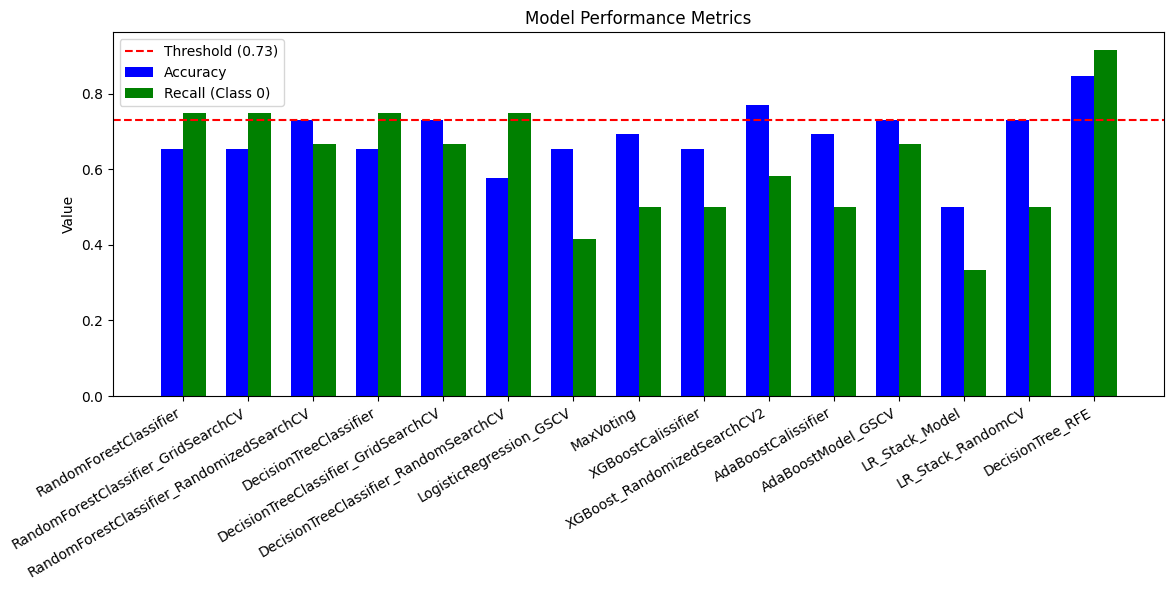

In [97]:
display_models()

# Conclusion

- DecisionTree is the best model for this dataset with a good trade-off in terms of accuracy and recall
- Using Recursive Feature Elimination (RFE) with Logistic Regression and DecistionTree, we were able to select the top 3 most important features
  - 'X1' : my order was delivered on time
  - 'X2': contents of my order was as I expected
  - 'X5' : I am satisfied with my courier

So these questions can help in improving the delivery process and improving customer satisfaction.

- The final model Based on Decision Tree using the # important features 'X1', 'X2', 'X5' achieved an accuracy of 85 % and recall for unhappy persons (Class ) of 93%.
- Using this model the company can predict whether a customer will be unhappy or not. It can be used for customer satisfaction management an improvement plan.
